In [12]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math 
import re

Fixes:
    
- Not just January of every year. 
- Judge name is sometimes mistaken for title
- Judgment --> take last 2 or 3 paragraphs for completeness. 
- Number of lawyers in case? Number of SCs
- Name conversion or mapping --> search bar list with names in case list
    

# Getting Case Links

In [13]:
case_links = []

for year in range(2017,2019):

    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    r = requests.get(f'http://www.hklii.org/eng/hk/cases/hkcfi/{year}/', headers = headers).text
    soup = BeautifulSoup(r, 'html.parser')

    #Going to skip months and cases for now to minimise requests!
    #1, 13, 2 is starting from january to december, skipping months
    for month in range(1, 13, 1):
        total = len(soup.findAll('ul')[month].findAll('a'))
        for each in range(0, total, 1):
            link = soup.findAll('ul')[month].findAll('a')[each]['href']
            link = link[2:]
            case_links.append(link)


In [14]:
tot = len(case_links)
print(tot)

3985


# Creating Case Summaries

In [ ]:
case_summaries = []
failed_links = []

for link in case_links: 
    try:
        newlink = 'http://www.hklii.org/eng/hk/cases/hkcfi' + link
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
        r = requests.get(newlink, headers = headers).text
        soup = BeautifulSoup(r, 'html.parser')

        plaintiff_rep = soup.find_all('representation')[0].find_all('p')[1].text
        defendant_rep = soup.find_all('representation')[0].find_all('p')[2].text
        paras = len(soup.find_all(class_ = 'para'))
        if paras > 2:
            decision = soup.find_all(class_ = 'para')[-3].parent.text + ' ' + soup.find_all(class_ = 'para')[-2].parent.text + ' ' + soup.find_all(class_ = 'para')[-1].parent.text
        elif paras == 2:
            decision = soup.find_all(class_ = 'para')[-2].parent.text + ' ' + soup.find_all(class_ = 'para')[-1].parent.text
        elif pars == 1:
            decision = soup.find_all(class_ = 'para')[-1].parent.text
        judge = soup.findAll('tr')[-3].text.strip() + soup.findAll('tr')[-2].text.strip()
        judge_title = soup.findAll('tr')[-1].text.strip()
        case = soup.find('title').text

        case_dict = {'p_rep': plaintiff_rep,
                     'd_rep': defendant_rep,
                     'decision': decision,
                     'judge': judge,
                     'judge_title': judge_title,
                     'link': link,
                     'case_name': case}

        print('just did: ' + case)
        case_summaries.append(case_dict)

    except:
        failed_links.append(link)
        print('FAIL')
    
    tot -= 1
    print(str(tot) + ' remaining')

Optimization terminated successfully.
         Current function value: 0.650220
         Iterations 4


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


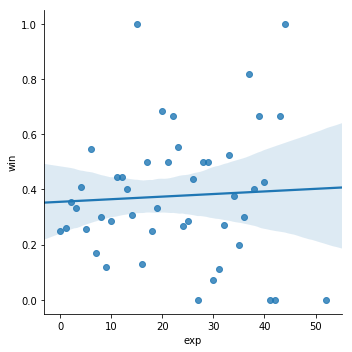

In [262]:
ee = cases_p.groupby('exp').mean()
ee.reset_index(inplace = True)
sns.lmplot(data = ee, x = 'exp', y = 'win')

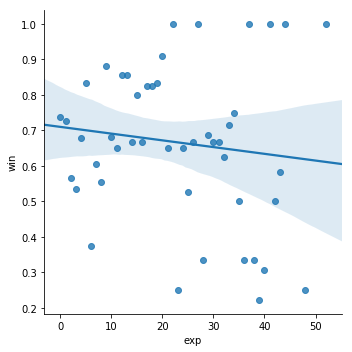

In [264]:
gg = cases_d.groupby('exp').mean()
gg.reset_index(inplace = True)
sns.lmplot(data = gg, x = 'exp', y = 'win')

In [282]:
ggg = cases_p.groupby('exp_class').mean()
ggg.reset_index(inplace = True)


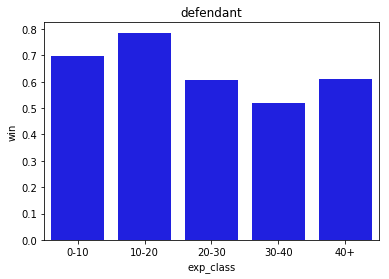

In [285]:
plt.title('defendant')
sns.barplot(data = eee, x = 'exp_class', y = 'win', color= 'blue')

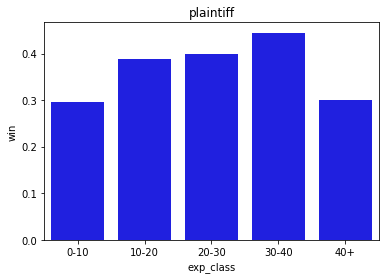

In [284]:
plt.title('plaintiff')
sns.barplot(data = ggg, x = 'exp_class', y = 'win', color= 'blue')

In [246]:
cases_d.groupby('win').mean()

,d_call,exp,intercept
win,,,
0,2001.298165,16.701835,1.0
1,2004.323144,13.676856,1.0


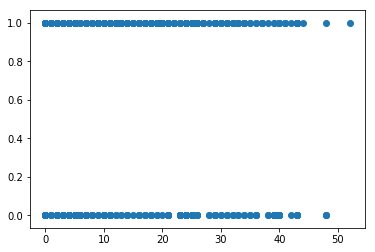

In [252]:
plt.scatter(data= cases_d, x = 'exp', y = 'win')


In [171]:
#cases.to_csv('cases_1718.csv', index = False)
#cases = pd.read_csv('cases_2017_2018.csv')
#bars = pd.read_csv('barristers.csv')

In [200]:
cases_d.to_csv('defendant_1718.csv', index = False)

# ALL THE STUFF TO CLEAN:

## Representatives:
- _Remove the \n_
- _Find the lead counsel (Ms. or Mr.)_
- Number of counsel?
- _Find the 'instructed by'_ 
- _Find all the in person_

**Here's how I'm doing it right now:**
- only use cases that confirm to a particular format. 
- Two rows of representation, one for P one for D
- Will only take the name of the LEAD counsel for each case and ignore others


## Decisions:
_- Need to get more of the decision_
    - sometimes sub-paragraphs are not extracted by the scraper
    - Sometimes, decision is higher up in the judgment
    
## To Do:
- Split the representation into p_bar, d_bar, p_firm, d_firm, account for multiple lawyers. 
- Improve the find_winner function --> aim for 75% confidence
- Improve the `find_call()` function, so it gets call AND inner call, and recalculates in reference to date of decision
    
## Analysis:
- Break table into P and D tables
- logistic regression, predict success on experience. 
- predict success on discrepancy 
- Bar chart --> group by exp class, hue by success/failure count
- Violin --> success on x, exp on y 

    
    

In [ ]:
#Find p_rep and d_rep from Representation
def find_rep(x):
    x = x.lower()
    try:
        first = re.findall('((mr|ms)?\.? .{0,39}),( (instructed|assigned) by (.{0,40}))?,? for the .{0,25}?(respondent|plaintiff|defendant|appellant|petitioner|applicant|HKSAR)?', x)[0]
        return first[0]
    except:
        if 'in person' in x:
            return 'in person'
        else:
            return np.nan

cases['p_rep'] = cases['representation'].apply(find_rep)
    
#Find Name of barrister:

def find_bar(x):
    x = x.lower()
    try:
        return re.findall('(mr|ms)\.? (.{0,20}),', x)[0][1]
    except: 
        if 'in person' in x:
            return 'in person'
        else:
            return np.nan
    
cases['p_bar'] = cases['p_rep'].apply(find_bar)
cases['d_bar'] = cases['d_rep'].apply(find_bar)

#Find Name of firm

def find_firm(x):
    try:
        x = x.replace('\n', ' ')
        return re.findall('instructed by (.{0,25}),', x)[0]
    except:
        return ''
    
cases['d_firm'] = cases['d_rep'].apply(find_firm)
cases['p_firm'] = cases['p_rep'].apply(find_firm)

In [ ]:
def judge_name(x):
    try:
        return re.findall('\((.+)\)', x)[0]
    except:
        return np.nan

cases2['judge_name'] = cases2['judge'] + cases2['judge_title']
cases2['judge_name'] = cases2['judge_name'].apply(judge_name)

Possible case decisions:

cases
'In favour of:'
'dismissed'
'allowed'
'do not accept'



In [ ]:
def find_winner(x):
    x = x.lower()
    if 'allowed' in x or 'allow' in x:
        return 'plaintiff'
    elif 'dismissed' in x or 'dismiss' in x:
        return 'defendant'
    elif 'do not accept' in x:
        return 'defendant'
    elif re.findall('favour of .+(Plaintiff|Defendant|defendant|plaintiff)', x):
        return re.findall('favour of .+(Plaintiff|Defendant|defendant|plaintiff)', x)[0].lower()
    elif re.findall('do not accept .+ (plaintiff|defendant)', x):
        if re.findall('do not accept .+ (plaintiff|defendant)', x)[0] == 'defendant':
            return 'plaintiff'
        elif re.findall('do not accept .+ (plaintiff|defendant)', x)[0] == 'plaintiff':
            return 'defendant'
    elif x.count('plaintiff') > x.count('defendant'):
        return 'plaintiff'
    elif x.count('defendant') > x.count('plaintiff'):
        return 'defendant'
    else:
        return 'unknown'

In [ ]:
def find_call(x):
    for each in bars['name']:
        if len(x.split(' ')) > 1:
            if x.split(' ')[0] in each:
                if x.split(' ')[1] in each:
                    i = bars.index[bars['name'] == each].tolist()[0]
                    return str(bars.iloc[i]['call'])
    return np.nan

cases2['p_call'] = cases2['p_bar'].apply(find_call)
cases2['d_call'] = cases2['d_bar'].apply(find_call)

#NEW VERSION
def find_call(x):
    for each in bars['name']:
        if len(x.split(' ')) > 1:
            if x.split(' ')[0].capitalize() in each:
                if x.split(' ')[1].capitalize() in each:
                    i = bars.index[bars['name'] == each].tolist()[0]
                    return str(bars.loc[i,'call'])
    return np.nan

cases_p['p_call'] = cases_p['p_bar'].apply(find_call)

#Find Inner Call
def find_sc(x):
    if ' sc' in x:
        for each in bars['name']:
            if len(x.split(' ')) > 1:
                if x.split(' ')[0].capitalize() in each:
                    if x.split(' ')[1].capitalize() in each:
                        i = bars.index[bars['name'] == each].tolist()[0]
                        return str(bars.loc[i,'innercall'])
    else:
        return np.nan

cases_p['p_inner'] = cases_p['p_bar'].apply(find_sc)

plaintiff sc --> 11/36  30.5%
plaintiff not sc -->    37.3%
Generally --> 35.8%

defendant sc -->        72.0%
defendant not sc -->    62.0%
Generally --> 64.2%

In [402]:
cleancases.groupby('winner').count()

,case_name,d_rep,decision,judge,judge_title,link,p_rep,p_bar,d_bar,d_firm,p_firm,p_call,d_call,p_sc,d_sc
winner,,,,,,,,,,,,,,,
defendant,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104
plaintiff,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58
unknown,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107


In [51]:
#STEPS:

cases_d = cases[['d_bar', 'winner']] 

def dummy(x):
    if x == 'defendant':
        return 1
    elif x == 'plaintiff':
        return 0
    else:
        return np.nan

cases_d['win'] = cases_d['winner'].apply(dummy)
cases_d.dropna(inplace = True, axis = 0)
cases_d['win'] = cases_d['win'].astype(int)

def find_call(x):
    for each in bars['name']:
        if len(x.split(' ')) > 1:
            if x.split(' ')[0].capitalize() in each:
                if x.split(' ')[1].capitalize() in each:
                    i = bars.index[bars['name'] == each].tolist()[0]
                    return str(bars.loc[i,'call'])
    if 'in person' in x:
        return '2018'
    return np.nan

cases_d['d_call'] = cases_d['d_bar'].apply(find_call)

#Find Inner Call
def find_sc(x):
    if ' sc' in x:
        for each in bars['name']:
            if len(x.split(' ')) > 1:
                if x.split(' ')[0].capitalize() in each:
                    if x.split(' ')[1].capitalize() in each:
                        i = bars.index[bars['name'] == each].tolist()[0]
                        return str(bars.loc[i,'innercall'])
    else:
        return np.nan

cases_d['d_inner'] = cases_d['d_bar'].apply(find_sc)



[]